# Evaluation for Simulations of the Experiments by Poletti et al. (2010)

This file contains the motion detection stages, including the GMDN set up and creates the resulting plots. The input is provided by the spike time/position files created by running `ms_network_no_m.py`. The parameters for motion detection and properties of the global motion detection can all be varied with a simple rerun of cells, which allows for quick investigation of the resulting behaviour of the model data.

In [ ]:
import sys
import os
import glob
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm 
import cv2
import datetime
import itertools
import scipy.stats

This function is used for error calculation at the end.

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

### Parameter

Here all parameters are set ecept $n_D$. Motion detectors are implemented by binning spikes and then comparing different bins in neighboring cells. 

- `t_full`: simulation time
- `t_bin`: interval length for binning in steps (1ms)
- `b_vels`: range of bins that get checked (including the upper limit). These are equivalent to velocity ranges for each bin, cf. [additional information](../../additional_info.ipynb)
- `n_gmdn`: the number of global motion detection neurons into which the simulated cells get divided in $x$- and $y$-direction, division into simple squares
- `npms`: number of neighboring cells that get checked for motion spikes, with the respective delay. For example 2 means that three cells in a row have to spikewith the respective delay fitted to motion velocity and direction.
- `gmd_thrs`: global motion detection threshold $N_g$ 
- `mo_det_thrs`: the minimum number of coincidence events for two intervals, 2 mean that in both cells at the given intervals two spikes must have been detected to spark a motion signal
- `md_num`: if `True`, the numbe rof motion detectors that fired during an interval will be contained in the result, otherwise the result for an intervla will be equal to 1, if any detector detected motion (simple presence of motion)
- `snums`: numbers of the included simulations
- `methods`: `"md_par"` means that the GMDNs are activated by parasol cells, `"md_md"` means by the respective motion detectors. Both can be simulated simultaneously.

In [ ]:
# simulation time
t_full = 1000

#time interval length for binning
t_bin = 15
#range of bins that get checked
b_vels = [3, 5]

#number of 
npms = 1

#this is the sqrt of the number of gmdns used (so how many in one direction)
n_gmdn = np.asarray([1])

#number of cells within RF firing accounted to global motion, set in cells
gmd_thrs = np.arange(20, 10, -1)

#number of coincidence events per bin
mo_det_thrs = np.arange(0, 1, 1)

# number of simulations
snums = np.arange(10, 31)

md_num = False

methods = ["md_par", "md_md"]

#will contain results, clear here as well
results = {}

Next, we need to set up the grid.

In [ ]:
#get position of parasol neurons for both file sizes
gp_file = open('../data/poletti2010/blocks/1/dot/p_pos_dot_1.data', 'rb')
gp_data = np.load(gp_file)
gp_file.close()

gp_m_file = open('../data/poletti2010/blocks/1/dot_m/p_pos_dot_m_1.data', 'rb')
gp_m_data = np.load(gp_m_file)
gp_m_file.close()

#get first nodes for both to attribute parasol cells right
first_node = 0
gid = open('../data/poletti2010/blocks/1/dot/network/GID_info.txt', 'r+')
for l in gid:
    if 'parasols' in l.split('\t')[0].strip():
        first_node = int(l.split('\t')[1].strip())
        
first_node_m = 0
gid_m = open('../data/poletti2010/blocks/1/dot_m/network/GID_info.txt', 'r+')
for l in gid_m:
    if 'parasols' in l.split('\t')[0].strip():
        first_node_m = int(l.split('\t')[1].strip())
        
f_n = first_node
n_pos_n = {}
swidth = 60.
sheight = 30.
for q in gp_data:
    for p in q:
        n_pos_n[f_n] = (int(p[0]/(swidth/float(n_gmdn))), 0) #(0, 0) 
        f_n += 1

f_m = first_node_m
n_pos_m = {}

swidth = 120.
for q in gp_m_data:
    for p in q:
        n_pos_m[f_m] = (int(p[0]/(swidth/float(n_gmdn))), int(p[0]/(sheight/float(n_gmdn)))) #(0, 0)
        f_m += 1      

### Simulation of Motion Detection Mechanism

This block gets the input form the file and runs the whole motion detection stage for each simulation. In the end it puts together the conditions by putting together the respective simulated blocks (border + dot) for each simulation. Data will be stored in form of 

`results[(<global motion detection threshold>, <spike number motion detection threshold>, <experiment nr>, <condition nr>, <simulation nr>, <GMDN input method>)]`

For the GMDN we assume that in the final stage it has to encompass the whole simulated region, dot and border, as otherwise the dot would not invoke enough cells to spike such that with the same motion applied to both objects a differential motion signal would arise. Therefore the GMDN data from the border region are also applied to the dot simulations.

In [ ]:
#names of included blocks, border (refernce frame) has to come first for comparison to work.
snames = ["border", "border_m", "dot", "dot_m"]

In [8]:
for thr in gmd_thrs:

    gmd_thr = thr

    for md_thr in mo_det_thrs:

        print('GDMN Nr ' + str(n_gmdn) + ' (' + str(int(len(gp_data)*len(gp_data[0])/(n_gmdn))) + 
              ' cells) GMDN threshold ' + str(thr) + ' cells, motion threshold ' + str(md_thr) + ' spikes.')

        in_data = {}
        bin_data = {}
        
        #iterate through all simulations
        for snum in snums:
            
            snum_name = str(snum)
            if snum == 10:
                snum_name = "fem_comp"

            print("simulation number " + str(snum))
            
            #open all four files and run, then store results in dict
            for sname in snames:
                in_data[(snum, sname)] = open('../data/poletti2010/blocks/' + snum_name + '/' + sname +
                                              '/network/spikes_parasols_' + sname + '_' +
                                              snum_name + '.txt', 'r+')

                if sname.count("_m") > 0:
                    n_pos = n_pos_m
                else:
                    n_pos = n_pos_n

                pos = []
                sp = []

                sp_pos = {}
                p = 0
                
                #extract the spike times from file
                for line in in_data[(snum, sname)]:
                    if len(line.split('[')) > 1:
                        p = int(line.split('[')[0])
                        spikes = line.split('[')[1]
                    if len(line.split(']')) > 0:
                        spikes = spikes.split(']')[0]
                        
                    #convert spike times to bin numbers 
                    sp_n = []
                    for s in spikes.split(' '):
                        if len(s.strip()) > 0:
                            pos += [p]
                            sp += [float(s)]
                            sp_n += [int((float(s)-0.01)/t_bin)]
                    #add position to 
                    sp_pos[p] = sp_n                        

                in_data[(snum, sname)].close()


                #store the number of parasol cells firing for each interval
                bins_par_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))
                bins_r_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))
                bins_l_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))

                #iterate through parasols
                for key in sp_pos:

                    #to check the number of parasol cells spiking within one bin
                    did_spike = list(set(sp_pos[key]))
                    #get number of parasol cells spiking wihtin one bin
                    for d_s in did_spike:
                        if sp_pos[key].count(d_s) > md_thr:
                            bins_par_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1

                    #get the number of motion detectors firing        
                    for d_s in did_spike:
                        
                        #rightward motion
                        fs = []
                        for npm in range(npms):
                            fs += [0]
                            #if cell fired at least once during simulaton time
                            if key - (npm + 1) in sp_pos:
                                #check specific intervals
                                for b_vel in range((npm  + 1) * b_vels[0], (npm  + 1) * b_vels[1] + 1):
                                    if (sp_pos[key].count(d_s) > md_thr and 
                                        sp_pos[key - (npm + 1)].count(d_s - b_vel) > md_thr):

                                        #set to 1, if 
                                        fs[npm] = 1

                        #leftward motion
                        fs_l = []
                        for npm in range(npms):
                            fs_l += [0]
                            if key + (npm + 1) in sp_pos:
                                for b_vel in range((npm  + 1) * b_vels[0], (npm + 1) * b_vels[1] + 1):
                                    if (sp_pos[key].count(d_s) > md_thr and 
                                        sp_pos[key + (npm + 1)].count(d_s - b_vel) > md_thr):

                                        fs_l[npm] = 1

                        #if motion detectors in both directions simultaneously detect a motion signal 
                        #-> suppress
                        if 0 not in fs and 0 in fs_l:
                            bins_r_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1

                        if 0 not in fs_l and 0 in fs:
                            bins_l_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1



                '''
                #GLOBAL MOTION DETECTION -- SKIPPED
                gmdns_par = (bins_par_num < gmd_thr).astype(int)
                gmdns_r = (bins_r_num < gmd_thr).astype(int)
                gmdns_l = (bins_l_num < gmd_thr).astype(int)     
                '''
                
                #If assuming one GMDN for both objects (>10deg) -> approximation, as few spikes for dot
                if sname.count("border") > 0:
                    if sname.count("_m") == 0:
                        g_b_par = copy.deepcopy((bins_par_num < gmd_thr).astype(int))
                        g_b_r = copy.deepcopy((bins_r_num < gmd_thr).astype(int))
                        g_b_l = copy.deepcopy((bins_l_num < gmd_thr).astype(int))
                        
                    else:
                        g_b_par_m = copy.deepcopy((bins_par_num < gmd_thr).astype(int))
                        g_b_r_m = copy.deepcopy((bins_r_num < gmd_thr).astype(int))
                        g_b_l_m = copy.deepcopy((bins_l_num < gmd_thr).astype(int))

                if sname.count("_m") > 0:       
                    gmdns_par = g_b_par_m
                    gmdns_r = g_b_r_m
                    gmdns_l = g_b_l_m
                    
                else:
                    gmdns_par = g_b_par
                    gmdns_r = g_b_r
                    gmdns_l = g_b_l
                # end for approximation    
                
                
                #if number of cells spiking in output
                if md_num:
                    bins_par_on_gmd = bins_par_num  * gmdns_par
                    bins_r_on_gmd_par = bins_r_num * gmdns_par
                    bins_l_on_gmd_par = bins_l_num * gmdns_par
                    bins_r_on_gmd_r = bins_r_num * gmdns_r
                    bins_l_on_gmd_l = bins_l_num * gmdns_l
                
                else:
                    bins_r_on_gmd_par = (bins_r_num > 0).astype(int) * gmdns_par
                    bins_l_on_gmd_par = (bins_l_num > 0).astype(int) * gmdns_par
                    bins_r_on_gmd_r = (bins_r_num > 0).astype(int) * gmdns_r
                    bins_l_on_gmd_l = (bins_l_num > 0).astype(int) * gmdns_l

                #difference in leftward vs. rightward motion.
                bins_lr_on_gmd_par = np.abs(bins_r_on_gmd_par - bins_l_on_gmd_par) 
                bins_lr_on_gmd_each = np.abs(bins_r_on_gmd_r - bins_l_on_gmd_l)


                #with several GMDNs, add data from each for each interval    
                bins_lr_on_gmd_par = np.add.reduce(bins_lr_on_gmd_par, 0)    
                bins_lr_on_gmd_par = np.add.reduce(bins_lr_on_gmd_par, 0)
                bins_lr_on_gmd_each = np.add.reduce(bins_lr_on_gmd_each, 0)    
                bins_lr_on_gmd_each = np.add.reduce(bins_lr_on_gmd_each, 0)

                
                # save data for evaluation
                bin_data[(snum, sname, "md_par")] = bins_lr_on_gmd_par
                bin_data[(snum, sname, "md_md")] = bins_lr_on_gmd_each




            # PUT EXPERIMENTS AND CONDITIONS TOGETHER
            # snum == 0: FEM compensated simulations
            if snum != 0:
                for method in methods:

                    # results[(exp, cond, snum, method)]

                    # EXPERIMENT 1
                    results[(thr, md_thr, "1", "1", snum, method)]  = bin_data[(snum, "dot", method)]
                    results[(thr, md_thr, "1", "1m", snum, method)] = bin_data[(snum, "dot_m", method)]

                    results[(thr, md_thr, "1", "2", snum, method)]  = bin_data[(10, "dot", method)]
                    results[(thr, md_thr, "1", "2m", snum, method)] = bin_data[(10, "dot_m", method)]


                    # EXPERIMENT 2
                    results[(thr, md_thr, "2", "1", snum, method)]  = bin_data[(snum, "dot", method)] - bin_data[(snum, "border", method)]
                    results[(thr, md_thr, "2", "1m", snum, method)] = bin_data[(snum, "dot_m", method)] - bin_data[(snum, "border", method)]

                    results[(thr, md_thr, "2", "2", snum, method)]  = bin_data[(10, "dot", method)] - bin_data[(snum, "border", method)]
                    results[(thr, md_thr, "2", "2m", snum, method)] = bin_data[(10, "dot_m", method)] - bin_data[(snum, "border", method)]

                    results[(thr, md_thr, "2", "3", snum, method)]  = bin_data[(10, "dot", method)] - bin_data[(10, "border", method)]
                    results[(thr, md_thr, "2", "3m", snum, method)] = bin_data[(10, "dot_m", method)] - bin_data[(10, "border", method)]

                    results[(thr, md_thr, "2", "4", snum, method)]  = bin_data[(snum, "dot", method)] - bin_data[(snum, "border_m", method)]
                    results[(thr, md_thr, "2", "4m", snum, method)] = bin_data[(snum, "dot_m", method)] - bin_data[(snum, "border_m", method)]


GDMN Nr [3] (40 cells) GMDN threshold 20 cells, motion threshold 0 spikes.
simulation number 10
simulation number 11
simulation number 12
simulation number 13
simulation number 14
simulation number 15
simulation number 16
simulation number 17
simulation number 18
simulation number 19
simulation number 20
simulation number 21
simulation number 22
simulation number 23
simulation number 24
simulation number 25
simulation number 26
simulation number 27
simulation number 28
simulation number 29
simulation number 30
GDMN Nr [3] (40 cells) GMDN threshold 19 cells, motion threshold 0 spikes.
simulation number 10
simulation number 11
simulation number 12
simulation number 13
simulation number 14
simulation number 15
simulation number 16
simulation number 17
simulation number 18
simulation number 19
simulation number 20
simulation number 21
simulation number 22
simulation number 23
simulation number 24
simulation number 25
simulation number 26
simulation number 27
simulation number 28
simulation

### Evaluation

This part contains the evaluation. In this first step, we simply count the number of intevrals with motion signal and normalize it to the simulation length. If `md_num` is true, the number of all cells that spiked during the simulated time gets plotted.

-----------------------------------------------------------------------------------------------------
VALUES FOR Parasols
-----------------------------------------------------------------------------------------------------


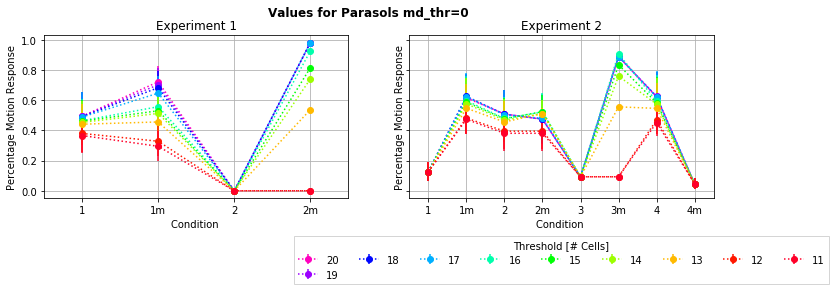

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion
-----------------------------------------------------------------------------------------------------


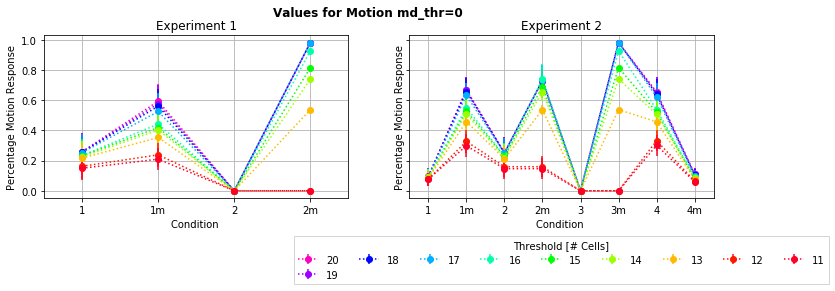

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion 2
-----------------------------------------------------------------------------------------------------


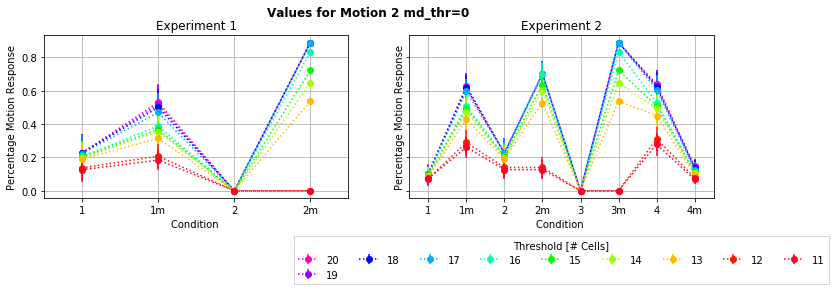

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion, MD
-----------------------------------------------------------------------------------------------------


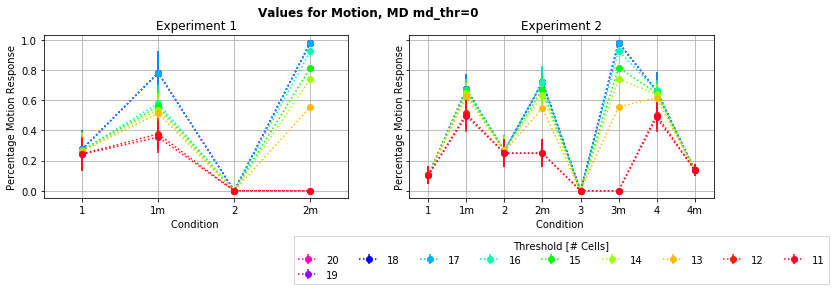

In [9]:
#the GMDN connections
methods = [("md_par", "Motion, Par")]
methods += [("md_md", "Motion, MD")]

snums = np.arange(11, 31)

for mi, meth in enumerate(methods):
    
    print('-----------------------------------------------------------------------------------------------------')
    print('VALUES FOR ' + meth[1])
    print('-----------------------------------------------------------------------------------------------------')

    #for motion detection spike thresholds
    for md_thr in mo_det_thrs:

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
        fig.suptitle(r'Values for ' + meth[1] + ' md_thr=' + str(md_thr), weight='bold')

        res_effect = [[[] for re in range(2)] for rg in range(len(gmd_thrs))]
        res_effect_std = [[[] for re in range(2)] for rg in range(len(gmd_thrs))]

        for j, exp in enumerate(["1", "2"]):

            #set specifics for each exp
            if exp == "1":
                conds = ["1", "1m", "2", "2m"]
            if exp == "2":
                conds = ["1", "1m", "2", "2m", "3", "3m", "4", "4m"]
            t_st = 0
            norm = int((t_full - t_st)/t_bin + 1)
            
            #iterate through GMDN thresholds
            for gtk, thr in enumerate(gmd_thrs):

                res_effect[gtk][j] = np.zeros(shape=(len(conds)), dtype=float)
                res_effect_std[gtk][j] = np.zeros(shape=(len(conds)), dtype=float)

                #iterate through conditions
                for q, cond in enumerate(conds):
                    
                    h_arr = np.zeros(shape=(len(snums)), dtype=float)
                    #iterate through simulation numbers
                    for s, snum in enumerate(snums):

                        #get number of bins which contain 1, then divide by number of all bins

                        #first plot max diff (=min) parasols + integral parasols + integral only during t_on
                        vals = copy.deepcopy(results[(thr, md_thr, exp, cond, snum, meth[0])][int(t_st/t_bin):int(t_full/t_bin)])

                        h_arr[s] = sum(np.abs(vals))/norm
                        
                    #get data and error
                    res_effect[gtk][j][q] = np.mean(h_arr)
                    res_effect_std[gtk][j][q] = np.std(h_arr)

                #gist_rainbow
                axes[j%2].errorbar(conds, res_effect[gtk][j], marker = 'o', linestyle=':', 
                               color = cm.gist_rainbow(1.-float(gtk)/(float(len(gmd_thrs)) - 1.6)), 
                               label=str(thr), yerr = res_effect_std[gtk][j])

            axes[j%2].set_xlim([-0.5, len(conds) - 0.5])
            axes[j%2].set_xticks(conds)
            axes[j%2].set_xlabel(r'Condition ')
            axes[j%2].set_ylabel('Percentage Motion Response') # [Normalized to Observation Time]')
            axes[j%2].grid()
            axes[j%2].set_title("Experiment " + exp)

            #axes[j%2].set_ylim([0, 1])
            box = axes[j%2].get_position()
            axes[j%2].set_position([box.x0, box.y0 + box.height * 0.25, box.width, 0.75 * box.height])

        axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, ncol=9, 
                       title='Threshold [# Cells]')
        #plt.savefig('../results/poletti2010/motion_values_' + meth[0].replace(" ", "") + '_gmd100_bin15_v2_4.pdf')
        plt.show()

From these data choose a threshold $n_D$ for the number of bins with motion detected, above which the trial is valued as "1". Apart from this, the code is as in the cell above.

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion
-----------------------------------------------------------------------------------------------------
[ 60.  90.   0. 100.]
[  0. 100.  45. 100.   0. 100. 100.   0.]


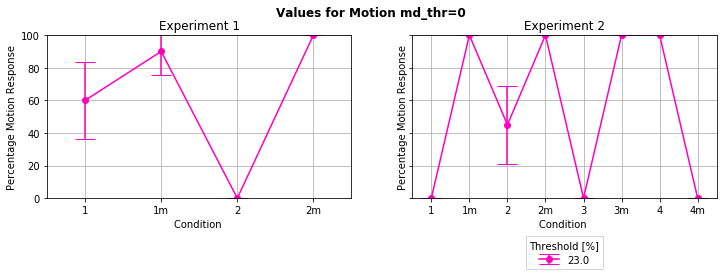

In [42]:
methods = []
methods += [("md_par", "Motion")]

snums = np.arange(11, 31)

# best fit would be gmd_thr=13, nthr=0., with bins=[3,5]
gmd_thr = 15
nthrs = [0.23] #np.arange(0.35, 0.55, 0.02)

for mi, meth in enumerate(methods):
    
    print('-----------------------------------------------------------------------------------------------------')
    print('VALUES FOR ' + meth[1])
    print('-----------------------------------------------------------------------------------------------------')

    for md_thr in mo_det_thrs:

        #plot integrals only during t_on for different exp, for different methods

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
        fig.suptitle(r'Values for ' + meth[1] + ' md_thr=' + str(md_thr), weight='bold')

        res_effect = [[[] for re in range(2)] for rg in range(len(nthrs))]
        res_effect_yerr = [[[] for re in range(2)] for rg in range(len(nthrs))]
        res_effect_le = [[[] for re in range(2)] for rg in range(len(nthrs))]
        res_effect_ue = [[[] for re in range(2)] for rg in range(len(nthrs))]

        for j, exp in enumerate(["1", "2"]):

            #set specifics for each exp
            if exp == "1":
                conds = ["1", "1m", "2", "2m"]
            if exp == "2":
                conds = ["1", "1m", "2", "2m", "3", "3m", "4", "4m"]
            t_st = 0
            norm = int((t_full - t_st)/t_bin + 1)

            for gtk, nthr in enumerate(nthrs):

                res_effect[gtk][j] = np.zeros(shape=(len(conds)), dtype=float)
                res_effect_yerr[gtk][j] = np.zeros(shape=(len(conds)), dtype=float)
                res_effect_le[gtk][j] = np.zeros(shape=(len(conds)), dtype=float)
                res_effect_ue[gtk][j] = np.zeros(shape=(len(conds)), dtype=float)

                for q, cond in enumerate(conds):
                    
                    h_arr = np.zeros(shape=(len(snums)), dtype=float)
                    for s, snum in enumerate(snums):

                        #get number of bins which contains 1, then divide by all number of bin 
                        vals = copy.deepcopy(results[(gmd_thr, md_thr, exp, cond, snum, meth[0])][int(t_st/t_bin):int(t_full/t_bin)])
                        
                        if sum(np.abs(vals))/norm >= nthr:
                            #print(sum(np.abs(vals))/norm)
                            h_arr[s] = 100
                        else:            
                            h_arr[s] = 0 #sum(hh_arr)/norm #sum(np.abs(vals))/norm
                        #'''
                        
                    # get data and error
                    res_effect[gtk][j][q] = mean_confidence_interval(h_arr, confidence=0.95)[0]
                    res_effect_le[gtk][j][q] = mean_confidence_interval(h_arr, confidence=0.95)[0] - mean_confidence_interval(h_arr, confidence=0.95)[1]
                    res_effect_ue[gtk][j][q] = mean_confidence_interval(h_arr, confidence=0.95)[2] - mean_confidence_interval(h_arr, confidence=0.95)[0]
                    #0 #np.std(h_arr) #/norm

                print(res_effect[gtk][j])
                #gist_rainbow
                axes[j%2].errorbar(conds, res_effect[gtk][j], marker = 'o', #linestyle=':', 
                                   color = cm.gist_rainbow((1.-float(gtk)/(float(len(nthrs)) - 0.4))),
                                   capsize=10, label=str(np.round(100.*nthr, 1)), 
                                   yerr=(res_effect_ue[gtk][j], res_effect_le[gtk][j])
                                  )
                
            bar_plot_arr = res_effect
            bar_plot_arr_le = res_effect_le
            bar_plot_arr_ue = res_effect_ue

            axes[j%2].set_xlim([-0.5, len(conds) - 0.5])
            axes[j%2].set_xticks(conds)
            axes[j%2].set_xlabel(r'Condition ')
            axes[j%2].set_ylabel('Percentage Motion Response') # [Normalized to Observation Time]')
            axes[j%2].grid()
            axes[j%2].set_title("Experiment " + exp)

            axes[j%2].set_ylim([0, 100])
            box = axes[j%2].get_position()
            axes[j%2].set_position([box.x0, box.y0 + box.height * 0.25, box.width, 0.75 * box.height])

        # Put a legend to the right of the current axis
        axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, ncol=9, 
                       title='Threshold [%]')
        #plt.savefig('../results/poletti2010/afc_' + meth[0].replace(" ", "") + '_gmd_'+str(gmd_thr)+'_bin15_v2_4.pdf')
        plt.show()

In [43]:
#get values
print(bar_plot_arr)
print(bar_plot_arr_le)
print(bar_plot_arr_ue)

[[array([ 60.,  90.,   0., 100.]), array([  0., 100.,  45., 100.,   0., 100., 100.,   0.])]]
[[array([23.52355959, 14.40517948,  0.        ,  0.        ]), array([ 0.        ,  0.        , 23.88828769,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])]]
[[array([23.52355959, 14.40517948,  0.        ,  0.        ]), array([ 0.        ,  0.        , 23.88828769,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])]]


### Calculate Correlation Coefficients

In [ ]:
exp_res_1 = np.asarray([1., 12.8, 10., 12., 7., 10., 5., 12.])/13.

exp_res_2 = np.asarray([1., 15., 10., 16., 1., 15., 14., 2.])/16.

sr_1 = np.append(res_2[0:4], res_1)

p_exp_1 = scipy.stats.pearsonr(exp_res_1, sr_1)
print("EXPERIMENT 1")
print(p_exp_1)

p_exp_2 = scipy.stats.pearsonr(exp_res_2, res_2)
print("EXPERIMENT 2")
print(p_exp_2)

sr_all =  np.append(sr_1, res_2)
exp_res_all =  np.append(exp_res_1, exp_res_2)

p_exp_all = scipy.stats.pearsonr(exp_res_all, sr_all)
print("BOTH EXPERIMENTS")
print(p_exp_all)

### Bar Plots

The rest of the file creates bar plots similar to those in the paper.

In [ ]:
#CREATE THE BAR PLOT FOR EXPERIMENT 1

#set plot styles
pgf_with_rc_fonts = {"font.family": "serif","font.serif": [],"font.sans-serif": []}
plt.rcParams.update(pgf_with_rc_fonts)

plt.close('all')

res_1 = copy.deepcopy(bar_plot_arr[0][0])
res_1_le = copy.deepcopy(bar_plot_arr_le[0][0])
res_1_ue = copy.deepcopy(bar_plot_arr_ue[0][0])
res_1_m = copy.deepcopy(bar_plot_arr[0][0])
res_1_m_le = copy.deepcopy(bar_plot_arr_le[0][0])
res_1_m_ue = copy.deepcopy(bar_plot_arr_ue[0][0])


res_2 = copy.deepcopy(bar_plot_arr[0][1])
res_2_le = copy.deepcopy(bar_plot_arr_le[0][1])
res_2_ue = copy.deepcopy(bar_plot_arr_ue[0][1])
res_2_m = copy.deepcopy(bar_plot_arr[0][1])
res_2_m_le = copy.deepcopy(bar_plot_arr_le[0][1])
res_2_m_ue = copy.deepcopy(bar_plot_arr_ue[0][1])


fig, ax = plt.subplots(2)
fig.set_size_inches(2.5,3.5)

print(res_2[0:4])
print(res_2_m[0:4])
index = np.arange(2)
bar_width = 0.35

opacity = 1.0 #0.7
error_config = {'ecolor': '0.3'}

rects1 = ax[1].bar(index  - 0.02, (res_1[0], res_1[2]), bar_width, alpha=opacity, color='lightgray', linewidth=0, 
                   capsize=2, yerr=((res_1_le[0], res_1_le[2]), (res_1_ue[0], res_1_ue[2])), error_kw=error_config, label='Dot still')

rects2 = ax[1].bar(index + bar_width + 0.02, (res_1[1], res_1[3]), bar_width, alpha=opacity, color='darkgray', linewidth=0,
                   capsize=2, yerr=((res_1_le[1], res_1_le[3]), (res_1_ue[1], res_1_ue[3])), error_kw=error_config, label='Dot moving')

rects3 = ax[0].bar(index - 0.02, (res_2[0], res_2[2]), bar_width, alpha=opacity, color='lightgray', linewidth=0, 
                   capsize=2, yerr=((res_2_le[0], res_2_le[2]), (res_2_ue[0], res_2_ue[2])), error_kw=error_config, label='Dot still')

rects4 = ax[0].bar(index + bar_width + 0.02, (res_2[1], res_2[3]), bar_width, alpha=opacity, color='darkgray', linewidth=0,
                   capsize=2, yerr=((res_2_le[1], res_2_le[3]), (res_2_ue[1], res_2_ue[3])), error_kw=error_config, label='Dot moving')

#plot styles
ax[0].set_title('Light',fontsize=11)
ax[1].set_title('Dark',fontsize=11)
ax[0].set_xlim([-0.4,1.8])
ax[1].set_xlim([-0.4,1.8])
ax[0].set_xticks([])
ax[1].set_xticks([-0.02,0.374 ,1.02,1.374])
ax[1].set_xticklabels(('1','1m','2','2m'))
ax[1].set_xlabel('Condition',fontsize=8)
ax[0].tick_params(axis='x',which='both',top='off',bottom='off',labelsize=8)
ax[0].tick_params(axis='y',which='both',left='on',right='off',labelsize=8)
ax[1].tick_params(axis='x',which='both',top='off',bottom='off',labelsize=8)
ax[1].tick_params(axis='y',which='both',left='on',right='off',labelsize=8)
ax[0].xaxis.set_ticks_position('bottom')
ax[0].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].yaxis.set_ticks_position('left')


ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylim(0,101)
ax[0].set_yticks(np.arange(0,101,20))

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylim(0,101)
ax[1].set_yticks(np.arange(0,101,20))

ax[0].set_axisbelow(True)
ax[0].grid(axis='y',color='lightgray', linestyle=':', linewidth=0.5)
ax[1].set_axisbelow(True)
ax[1].grid(axis='y',color='lightgray', linestyle=':', linewidth=0.5)
art=[]
lgd = ax[0].legend(bbox_to_anchor=(0,-.2,1.,.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, fontsize=8, frameon=False)
art.append(lgd)
plt.tight_layout()


plt.tight_layout()
#plt.savefig('poletti/poletti_1D_exp1_parasol_15ms_results.pgf', additional_artists=art,bbox_inches="tight")
#plt.savefig('../results/final/poletti_exp1_all_15ms_results.pdf', additional_artists=art,bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
#CREATE THE BAR PLOT FOR EXPERIMENT 2

fig, ax2 = plt.subplots(1)
fig.set_size_inches(3.5,2)

index = np.arange(4)
bar_width = 0.35

opacity = 1. #0.7
error_config = {'ecolor': '0.3'}

rects1 = ax2.bar(index  - 0.02, (res_2[0], res_2[2], res_2[4], res_2[6]), bar_width, alpha=opacity, 
                 color='lightgray', linewidth=2, capsize=2, edgecolor='k',
                 yerr=((res_2_le[0], res_2_le[2], res_2_le[4], res_2_le[6]), 
                       (res_2_ue[0], res_2_ue[2], res_2_ue[4], res_2_ue[6])), error_kw=error_config, 
                 label='Dot Still')

rects2 = ax2.bar(index + bar_width + 0.02, (res_2[1], res_2[3], res_2[5], res_2[7]), bar_width, alpha=opacity, 
                 color='darkgray', linewidth=2, capsize=2, edgecolor='k',
                 yerr=((res_2_le[1], res_2_le[3], res_2_le[5], res_2_le[7]), 
                       (res_2_ue[1], res_2_ue[3], res_2_ue[5], res_2_ue[7])), error_kw=error_config, 
                 label='Dot Moving')

rects1[1].set_edgecolor('r')
rects1[3].set_edgecolor('r')
rects2[0].set_edgecolor('r')
rects2[1].set_edgecolor('r')
rects2[2].set_edgecolor('r')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel('% Differential Motion',fontsize=8)
ax2.set_xlabel('Condition',fontsize=8)
ax2.set_ylim(0,101)
ax2.set_yticks(np.arange(0,101,20))
ax2.set_xticks([0.0,0.354,1.,1.354,2.,2.354,3.,3.354])
ax2.set_xticklabels(('1','1m','2','2m','3','3m','4','4m'))
plt.tick_params(axis='x', which='both', top='off', bottom='off', labelsize=8)
plt.tick_params(axis='y', which='both', left='on', right='off', labelsize=8)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgray', linestyle=':', linewidth=0.5)
art=[]
lgd = ax2.legend(bbox_to_anchor=(0,1.02,1.,.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, fontsize=8, frameon=False)

art.append(lgd)
plt.tight_layout()
#plt.savefig('poletti/poletti_1D_exp2_parasol_15ms_results.pgf', additional_artists=art,bbox_inches="tight")
#plt.savefig('../results/final/poletti_exp2_all_15ms_results.pdf', additional_artists=art,bbox_inches="tight")
plt.show()

[  0. 100.  45. 100.]
[  0. 100.  45. 100.]


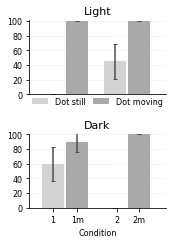

In [44]:
#CREATE THE BAR PLOT FOR EXPERIMENT 2

fig, ax2 = plt.subplots(1)
fig.set_size_inches(3.5,2)

index = np.arange(4)
bar_width = 0.35

opacity = 1. #0.7
error_config = {'ecolor': '0.3'}

rects1 = ax2.bar(index  - 0.02, (res_2[0], res_2[2], res_2[4], res_2[6]), bar_width, alpha=opacity, 
                 color='lightgray', linewidth=2, capsize=2, edgecolor='k',
                 yerr=((res_2_le[0], res_2_le[2], res_2_le[4], res_2_le[6]), 
                       (res_2_ue[0], res_2_ue[2], res_2_ue[4], res_2_ue[6])), error_kw=error_config, 
                 label='Dot Still')

rects2 = ax2.bar(index + bar_width + 0.02, (res_2[1], res_2[3], res_2[5], res_2[7]), bar_width, alpha=opacity, 
                 color='darkgray', linewidth=2, capsize=2, edgecolor='k',
                 yerr=((res_2_le[1], res_2_le[3], res_2_le[5], res_2_le[7]), 
                       (res_2_ue[1], res_2_ue[3], res_2_ue[5], res_2_ue[7])), error_kw=error_config, 
                 label='Dot Moving')

rects1[1].set_edgecolor('r')
rects1[3].set_edgecolor('r')
rects2[0].set_edgecolor('r')
rects2[1].set_edgecolor('r')
rects2[2].set_edgecolor('r')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel('% Differential Motion',fontsize=8)
ax2.set_xlabel('Condition',fontsize=8)
ax2.set_ylim(0,101)
ax2.set_yticks(np.arange(0,101,20))
ax2.set_xticks([0.0,0.354,1.,1.354,2.,2.354,3.,3.354])
ax2.set_xticklabels(('1','1m','2','2m','3','3m','4','4m'))
plt.tick_params(axis='x', which='both', top='off', bottom='off', labelsize=8)
plt.tick_params(axis='y', which='both', left='on', right='off', labelsize=8)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgray', linestyle=':', linewidth=0.5)
art=[]
lgd = ax2.legend(bbox_to_anchor=(0,1.02,1.,.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, fontsize=8, frameon=False)

art.append(lgd)
plt.tight_layout()
#plt.savefig('poletti/poletti_1D_exp2_parasol_15ms_results.pgf', additional_artists=art,bbox_inches="tight")
#plt.savefig('../results/final/poletti_exp2_all_15ms_results.pdf', additional_artists=art,bbox_inches="tight")
plt.show()

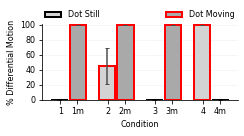

In [45]:
#CREATE THE BAR PLOT FOR EXPERIMENT 2

fig, ax2 = plt.subplots(1)
fig.set_size_inches(3.5,2)

index = np.arange(4)
bar_width = 0.35

opacity = 1. #0.7
error_config = {'ecolor': '0.3'}

rects1 = ax2.bar(index  - 0.02, (res_2[0], res_2[2], res_2[4], res_2[6]), bar_width, alpha=opacity, 
                 color='lightgray', linewidth=2, capsize=2, edgecolor='k',
                 yerr=((res_2_le[0], res_2_le[2], res_2_le[4], res_2_le[6]), 
                       (res_2_ue[0], res_2_ue[2], res_2_ue[4], res_2_ue[6])), error_kw=error_config, 
                 label='Dot Still')

rects2 = ax2.bar(index + bar_width + 0.02, (res_2[1], res_2[3], res_2[5], res_2[7]), bar_width, alpha=opacity, 
                 color='darkgray', linewidth=2, capsize=2, edgecolor='k',
                 yerr=((res_2_le[1], res_2_le[3], res_2_le[5], res_2_le[7]), 
                       (res_2_ue[1], res_2_ue[3], res_2_ue[5], res_2_ue[7])), error_kw=error_config, 
                 label='Dot Moving')

rects1[1].set_edgecolor('r')
rects1[3].set_edgecolor('r')
rects2[0].set_edgecolor('r')
rects2[1].set_edgecolor('r')
rects2[2].set_edgecolor('r')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel('% Differential Motion',fontsize=8)
ax2.set_xlabel('Condition',fontsize=8)
ax2.set_ylim(0,101)
ax2.set_yticks(np.arange(0,101,20))
ax2.set_xticks([0.0,0.354,1.,1.354,2.,2.354,3.,3.354])
ax2.set_xticklabels(('1','1m','2','2m','3','3m','4','4m'))
plt.tick_params(axis='x', which='both', top='off', bottom='off', labelsize=8)
plt.tick_params(axis='y', which='both', left='on', right='off', labelsize=8)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgray', linestyle=':', linewidth=0.5)
art=[]
lgd = ax2.legend(bbox_to_anchor=(0,1.02,1.,.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, fontsize=8, frameon=False)

art.append(lgd)
plt.tight_layout()
#plt.savefig('poletti/poletti_1D_exp2_parasol_15ms_results.pgf', additional_artists=art,bbox_inches="tight")
#plt.savefig('../results/final/poletti_exp2_all_15ms_results.pdf', additional_artists=art,bbox_inches="tight")
plt.show()